In [1]:
%load_ext autoreload
%autoreload 2 

## Imports

In [2]:
import pandas as pd
import logging

from cts_recommender.settings import get_settings
from cts_recommender.logging_setup import setup_logging
from cts_recommender.io import readers
from cts_recommender.environments.TV_environment import TVProgrammingEnvironment
from cts_recommender.models.audience_regression.audience_ratings_regressor import AudienceRatingsRegressor
from cts_recommender.imitation_learning.IL_training import HistoricalDataProcessor

cfg = get_settings()

setup_logging("INFO")
logger = logging.getLogger(__name__)

## Open Data and Load environment

In [3]:
catalog_df = readers.read_parquet(cfg.processed_dir / "whatson" / "whatson_catalog.parquet")
historical_programming_df = readers.read_parquet(cfg.processed_dir / "programming" / "historical_programming.parquet")
audience_model = AudienceRatingsRegressor()
audience_model.load_model(cfg.models_dir / "audience_ratings_model.joblib")

2025-10-21 15:52:15 INFO cts_recommender.models.audience_regression.audience_ratings_regressor: Model loaded from data/models/audience_ratings_model.joblib with 71 features


In [4]:
env = TVProgrammingEnvironment(catalog_df, historical_programming_df, audience_model)

2025-10-21 15:52:15 INFO cts_recommender.environments.TV_environment: Setting up CompetitorDataManager...
2025-10-21 15:52:15 INFO cts_recommender.environments.TV_environment: Setting up Scalers...
2025-10-21 15:52:16 INFO cts_recommender.environments.TV_environment: Setting up RewardCalculator...
2025-10-21 15:52:16 INFO cts_recommender.environments.reward: RewardCalculator initialized successfully.


In [5]:
hist_data_processor = HistoricalDataProcessor(env, 
                                            env.interest_historical_programming_df, 
                                            time_split_date='2024-12-20')


In [6]:
import joblib
training_samples = joblib.load(cfg.processed_dir / "IL" / "training_samples.joblib")
print(f"Loaded {len(training_samples)} training samples")
print(f"Sample keys: {training_samples[0].keys()}")

Loaded 7206 training samples
Sample keys: dict_keys(['context_features', 'movie_features', 'movie_id', 'selected', 'reward', 'value_signals', 'date', 'context_cache_key', 'current_memory'])


## Visualize Reward Signal Distributions

In [7]:
# Extract reward signals from all samples
from cts_recommender.utils.visualization import extract_reward_signals, print_reward_statistics

signals = extract_reward_signals(training_samples)
print_reward_statistics(signals)

Extracted 7206 reward signals

Audience     - range: [0.016, 1.000], mean: 0.551, median: 0.642
Competition  - range: [0.000, 1.000], mean: 0.204, median: 0.200
Diversity    - range: [0.149, 0.666], mean: 0.322, median: 0.311
Novelty      - range: [0.002, 1.000], mean: 0.951, median: 1.000
Rights       - range: [0.000, 1.000], mean: 0.196, median: 0.100


## Signal Correlation Analysis

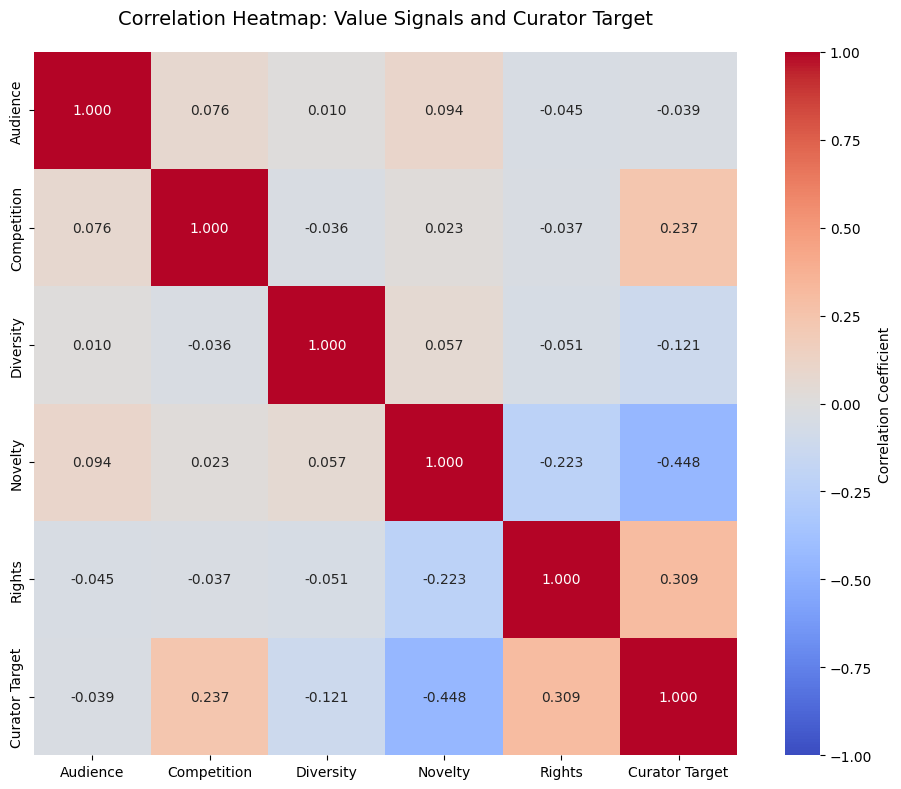


Key Correlations with Curator Target:
  Audience       : -0.039
  Competition    :  0.237
  Diversity      : -0.121
  Novelty        : -0.448
  Rights         :  0.309


Key Inter-Signal Correlations (|r| > 0.3):


In [8]:
# Create correlation heatmap of value signals and curator target
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Build a matrix with all signals plus curator target
signal_names = ['Audience', 'Competition', 'Diversity', 'Novelty', 'Rights', 'Curator Target']

# Extract data from training samples
data_matrix = []
for sample in training_samples:
    vs = sample['value_signals']
    row = [
        vs['audience'],
        vs['competition'],
        vs['diversity'],
        vs['novelty'],
        vs['rights'],
        float(sample['selected'])  # Curator target (1 if selected, 0 if not)
    ]
    data_matrix.append(row)

data_matrix = np.array(data_matrix)

# Calculate correlation matrix
corr_matrix = np.corrcoef(data_matrix.T)

# Create heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt='.3f', 
    cmap='coolwarm', 
    center=0,
    square=True,
    xticklabels=signal_names,
    yticklabels=signal_names,
    vmin=-1, 
    vmax=1,
    cbar_kws={'label': 'Correlation Coefficient'},
    ax=ax
)
plt.title('Correlation Heatmap: Value Signals and Curator Target', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Print key correlations with curator target
print("\nKey Correlations with Curator Target:")
print("=" * 50)
for i, name in enumerate(signal_names[:-1]):  # Exclude Curator Target itself
    corr = corr_matrix[i, -1]
    print(f"  {name:15s}: {corr:6.3f}")

print("\n\nKey Inter-Signal Correlations (|r| > 0.3):")
print("=" * 50)
for i in range(len(signal_names) - 1):
    for j in range(i + 1, len(signal_names) - 1):  # Exclude Curator Target
        corr = corr_matrix[i, j]
        if abs(corr) > 0.3:
            print(f"  {signal_names[i]:15s} <-> {signal_names[j]:15s}: {corr:6.3f}")

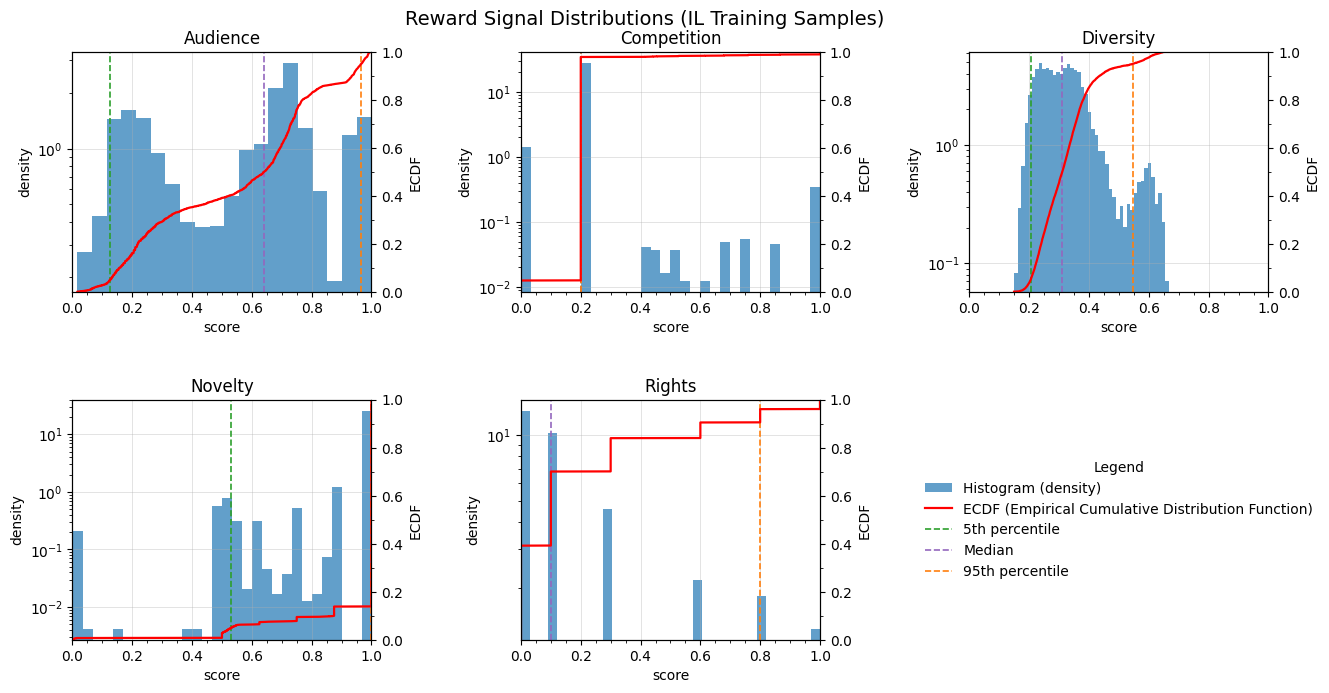

In [9]:
# Create visualization with 5 subplots for each reward component
from cts_recommender.utils.visualization import plot_reward_distributions
import matplotlib.pyplot as plt

# Prepare signals dict with capitalized names for display
signals_display = {
    "Audience": signals['audience'],
    "Competition": signals['competition'],
    "Diversity": signals['diversity'],
    "Novelty": signals['novelty'],
    "Rights": signals['rights'],
}

# Create the plot
fig, axes = plot_reward_distributions(
    signals_display,
    title="Reward Signal Distributions (IL Training Samples)"
)
plt.show()

## Training data

In [10]:
import joblib
training_data_file = cfg.processed_dir / "IL" / "training_data.joblib"
training_data = joblib.load(training_data_file)
training_data.keys()

dict_keys(['train', 'val'])

## Load Curator Logistic Regression model

In [11]:
from cts_recommender.models.curator_logistic_regressor import load_curator_model
curator_model = load_curator_model("data/models/curator_logistic_model.joblib")

2025-10-21 15:52:23 INFO cts_recommender.models.curator_logistic_regressor: Loading curator model from data/models/curator_logistic_model.joblib
2025-10-21 15:52:23 INFO cts_recommender.models.curator_logistic_regressor: Curator model loaded successfully


## Prepare training Data for CTS


In [12]:
import numpy as np

# Combine training and validation data for CTS warm-start

context_features = np.concatenate((training_data['train']['context_features'], training_data['val']['context_features']))  # numpy array
movie_features = np.concatenate((training_data['train']['movie_features'], training_data['val']['movie_features']))      # numpy array
context_dim = context_features.shape[1]
movie_dim = movie_features.shape[1]

logger.info(f"Context feature dimension: {context_dim}")
logger.info(f"Movie feature dimension: {movie_dim}")
logger.info(f"Total samples for CTS warm-start: {context_features.shape[0]}")

2025-10-21 15:52:23 INFO __main__: Context feature dimension: 16
2025-10-21 15:52:23 INFO __main__: Movie feature dimension: 24
2025-10-21 15:52:23 INFO __main__: Total samples for CTS warm-start: 7206


In [13]:
# For CTS, we need 6 signals:
# 1-5: audience, competition, diversity, novelty, rights (from value_signals)
# 6: curator_acceptance (binary 1/0 for offline warm-start, probability from logistic model for online learning)

# Extract signal values from training samples and construct signal matrix
def extract_signal_matrix_from_samples(samples):
    """
    Extract 6-dimensional signal vectors from training samples.
    
    Returns:
        signal_matrix: (n_samples, 6) array with [audience, competition, diversity, novelty, rights, curator_acceptance]
    """
    signal_list = []
    for sample in samples:
        # Get the 5 value signals
        value_signals = sample['value_signals']
        signals = [
            value_signals['audience'],
            value_signals['competition'],
            value_signals['diversity'],
            value_signals['novelty'],
            value_signals['rights'],
            float(sample['selected'])  # Curator acceptance (1 if selected, 0 if not)
        ]
        signal_list.append(signals)
    return np.array(signal_list)

# Extract signal matrices for train and val
train_signals = extract_signal_matrix_from_samples([s for s in training_samples])

# Number of signals (6: audience, competition, diversity, novelty, rights, curator_acceptance)
num_signals = train_signals.shape[1]

logger.info(f"Signal matrix shape: {train_signals.shape}")
logger.info(f"Signal ordering: [audience, competition, diversity, novelty, rights, curator_acceptance]")

2025-10-21 15:52:23 INFO __main__: Signal matrix shape: (7206, 6)
2025-10-21 15:52:23 INFO __main__: Signal ordering: [audience, competition, diversity, novelty, rights, curator_acceptance]


## Initialize CTS

In [50]:
# Initialize Contextual Thompson Sampler
from cts_recommender.models.contextual_thompson_sampler import ContextualThompsonSampler

cts = ContextualThompsonSampler(
    num_signals=num_signals,
    context_dim=context_dim,
    lr=0.05,              # Learning rate for online updates
    expl_scale=0.001,       # Exploration noise scale 0.01
    ema_decay=0.999,      # EMA decay for Hessian approximation
    h0=1e-1,               # Initial Hessian value 1.0
    tau=2.0,             # Temperature for softmax (5.0 for more uniform distribution)
    alpha=0.3,            # Uniform mixing weight (to 0.5 for 50/50 softmax/uniform mix)
    weight_decay=1e-4,    # Weight decay for regularization
    match_loss_weight=0.5, # Weight for signal matching loss
    random_state=cfg.random_seed
)

logger.info(f"Initialized CTS with {num_signals} signals and {context_dim} context features")
logger.info(f"U and b initialized to ZERO for uniform starting weights")
logger.info(f"Exploration noise std = sqrt(expl_scale/h0) = sqrt({cts.expl_scale}/{cts.h0}) = {np.sqrt(cts.expl_scale/cts.h0):.3f}")

2025-10-21 17:49:40 INFO __main__: Initialized CTS with 6 signals and 16 context features
2025-10-21 17:49:40 INFO __main__: U and b initialized to ZERO for uniform starting weights
2025-10-21 17:49:40 INFO __main__: Exploration noise std = sqrt(expl_scale/h0) = sqrt(0.001/0.1) = 0.100


### (Optional) Initialize with Target Weights

This section demonstrates how to initialize the CTS with specific target weight distributions instead of starting from uniform weights. This can help prevent one signal from dominating early in training.

In [51]:
# Initialize CTS with target weights based on IL pseudo-reward weights
# This reflects the curator's implicit preferences from the reward model

from cts_recommender.imitation_learning.IL_constants import PSEUDO_REWARD_WEIGHTS

USE_IL_BASED_INIT = False  # Set to True to use IL-based initialization

if USE_IL_BASED_INIT:
    signal_names_short = ['Audience', 'Competition', 'Diversity', 'Novelty', 'Rights', 'Curator']
    
    # Extract the 5 pseudo-reward weights (without curator signal)
    pseudo_weights = np.array([
        PSEUDO_REWARD_WEIGHTS['audience'],
        PSEUDO_REWARD_WEIGHTS['competition'],
        PSEUDO_REWARD_WEIGHTS['diversity'],
        PSEUDO_REWARD_WEIGHTS['novelty'],
        PSEUDO_REWARD_WEIGHTS['rights']
    ])
    
    # The IL reward formula combines curator selection with pseudo-rewards:
    # reward = gamma * curator_selection + (1 - gamma) * weighted_pseudo_reward
    # where weighted_pseudo_reward = sum(signal_i * pseudo_weight_i)
    
    # For CTS initialization, we want to reflect this in the signal weights
    # The curator signal gets weight gamma, and the other 5 signals share (1-gamma)
    
    # Get gamma from IL training processor (or use a reasonable default)
    gamma = hist_data_processor.gamma  # This should match the gamma used in IL training
    
    # Allocate gamma weight to curator signal, (1-gamma) to the other 5 signals
    target_weights = np.zeros(num_signals)
    target_weights[:5] = (1 - gamma) * pseudo_weights  # First 5 signals scaled by (1-gamma)
    target_weights[5] = gamma  # Curator signal gets gamma weight
    
    logger.info(f"Initializing CTS with IL-based target weights (gamma={gamma}):")
    logger.info(f"  Formula: weight_i = gamma * curator + (1-gamma) * pseudo_weight_i")
    logger.info(f"")
    for i, name in enumerate(signal_names_short):
        logger.info(f"  {name:12s}: {target_weights[i]:.4f}")
    logger.info(f"  Sum: {target_weights.sum():.4f}")
    
    # Apply initialization
    cts.initialize_with_target_weights(target_weights)
    
    # Verify the initialization worked
    sample_context = context_features[0]
    test_weights, _ = cts._compute_w(cts.U, cts.b, sample_context)
    
    logger.info(f"\nActual weights after initialization:")
    for i, name in enumerate(signal_names_short):
        logger.info(f"  {name:12s}: {test_weights[i]:.4f}")
    
    logger.info(f"\nBias vector (b): {cts.b}")
else:
    logger.info("Using default zero initialization (U=0, b=0 → uniform weights)")

2025-10-21 17:49:40 INFO __main__: Using default zero initialization (U=0, b=0 → uniform weights)


### Visualize Untrained CTS Weights (Before Warm-Start)

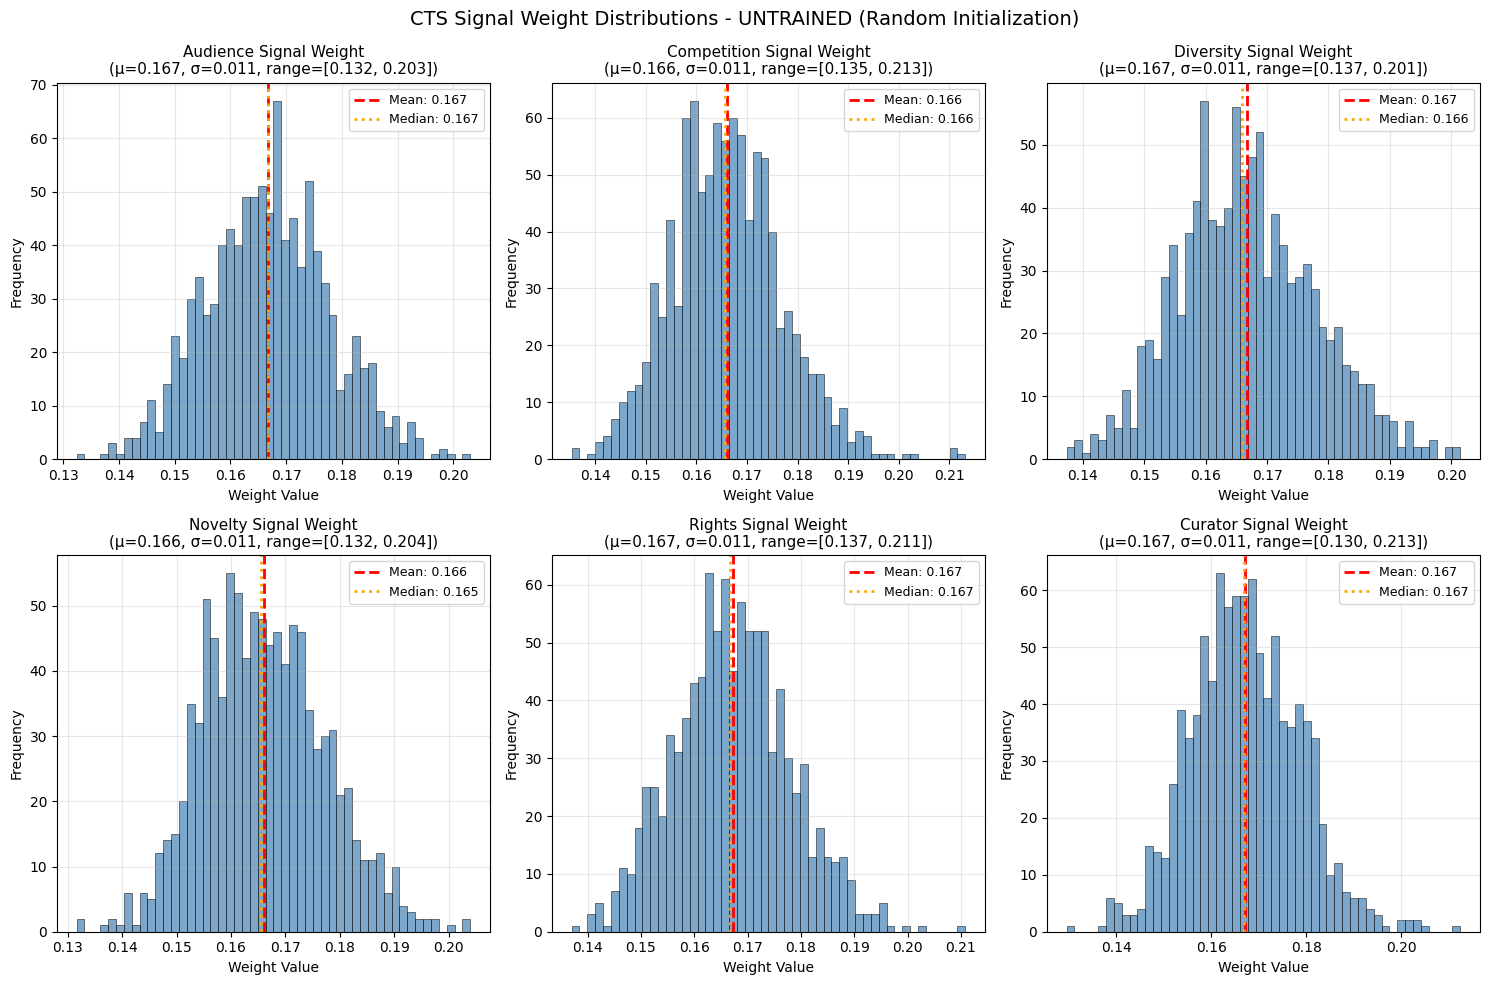


Note: These weights are from random initialization before any training.
The model uses small random values from standard normal distribution.


In [52]:
# Visualize weight distributions BEFORE warm-start training
# This shows the initial random weights from the CTS initialization

from cts_recommender.utils.visualization import visualize_cts_signal_weight_distributions

fig, axes = visualize_cts_signal_weight_distributions(
    cts_model=cts,
    env=env,
)
plt.suptitle('CTS Signal Weight Distributions - UNTRAINED (Random Initialization)', 
             fontsize=14, y=0.98)
plt.show()

print("\nNote: These weights are from random initialization before any training.")
print("The model uses small random values from standard normal distribution.")

## Warm-start CTS with Monitoring

In [53]:
# Perform warm-start training on historical data with monitoring
# Use all data (train + val combined) for warm-start - no need for separation here
from cts_recommender.utils.visualization import plot_cts_training_history, print_cts_training_summary

logger.info(f"Starting warm-start training with monitoring...")

# Warm-start training hyperparameters
epochs = 1
lr = 5e-2
expl_scale = 0.001  # Low noise during training 0.01
ema_decay = 0.9999   # Faster EMA accumulation (was 0.9999)
monitor_every = 500  # Track metrics every 500 updates

logger.info(f"Training for {epochs} epochs with lr={lr}, ema_decay={ema_decay}")

history = cts.warm_start(
    contexts=context_features,
    signals=train_signals,
    rewards=np.concatenate((training_data['train']['reward_targets'], 
                           training_data['val']['reward_targets'])),
    epochs=epochs,
    lr=lr,
    expl_scale=expl_scale,
    ema_decay=ema_decay,
    monitor_every=monitor_every,
    weight_decay=cts.weight_decay,
    verbose=True  # Print epoch summaries
)

logger.info("Warm-start training completed")

2025-10-21 17:49:42 INFO __main__: Starting warm-start training with monitoring...
2025-10-21 17:49:42 INFO __main__: Training for 1 epochs with lr=0.05, ema_decay=0.9999
2025-10-21 17:49:43 INFO __main__: Warm-start training completed


Epoch 1/1: avg_loss=0.053258, |U|=4.8674, |b|=3.9986, h_U_median=0.048645


In [54]:
# Print detailed training summary
print_cts_training_summary(history)

CTS WARM-START TRAINING SUMMARY

Training Progress:
  Total updates: 7,000
  Epochs completed: 0.97
  Monitoring points: 14

Parameter Evolution:
  ||U|| : 0.430138 → 4.753777 (change: +4.323640)
  ||b|| : 0.352306 → 3.905587 (change: +3.553281)
  max|U|: 0.258141 → 3.172326
  max|b|: 0.258141 → 3.172326

Curvature (h_U) Evolution:
  Initial h_U (h0): 0.095123
  Final h_U mean:   0.049660 (↓ 47.8%)
  Final h_U median: 0.049658
  Final h_U range:  [0.049657, 0.049701]

Gradient Statistics (final epoch):
  ||grad_U||: 0.018755
  ||grad_b||: 0.010627
  max|grad_U|: 0.009049
  max|grad_b|: 0.008771

Noise Levels:
  Initial noise_std(U): 0.102531
  Final noise_std(U):   0.141905

Signal-to-Noise Ratio:
  Final SNR: 8.95 ✅ (target: ≥3.0)

Training Loss:
  Initial: 0.019141
  Final:   0.050575
  Reduction: -164.2%


## Visualize Training Dynamics

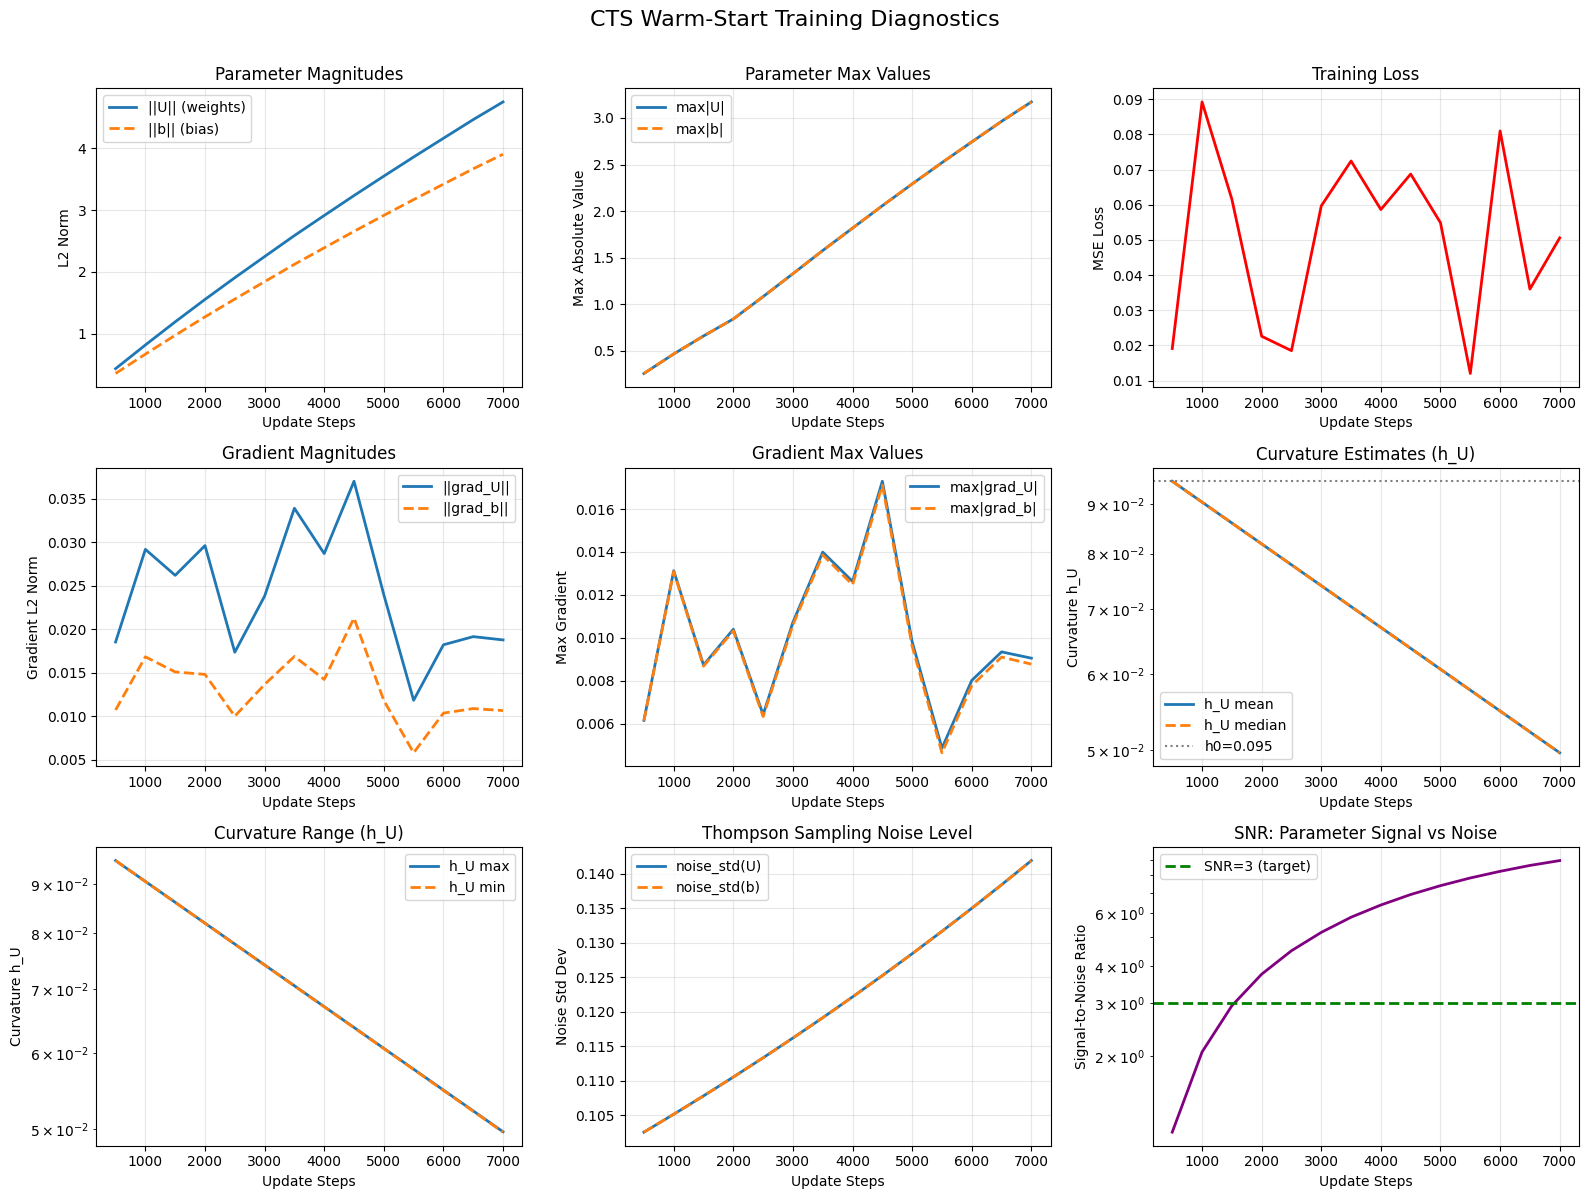

In [55]:
# Visualize all training metrics in a comprehensive dashboard
fig, axes = plot_cts_training_history(history)
plt.show()

## h_U Decay Diagnostic

## Test Trained CTS Signal Weighting

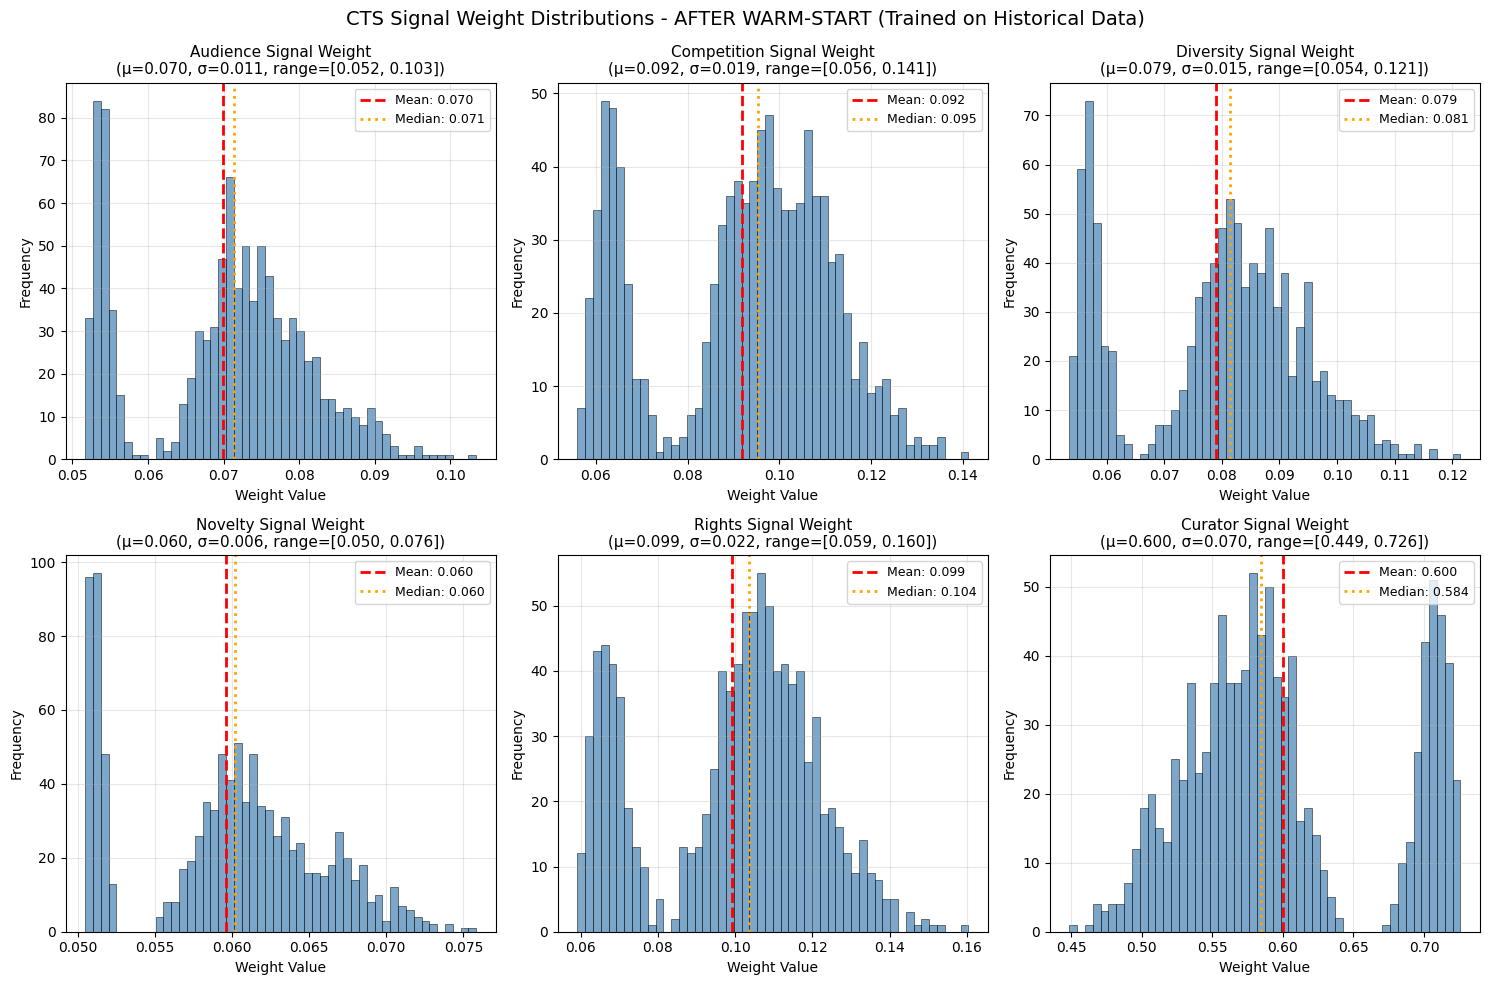


Note: These weights are learned from historical curator decisions.
Compare with the untrained weights above to see the effect of warm-start training.


In [56]:
# Visualize weight distributions AFTER warm-start training
# This shows the learned weights after training on historical data

from cts_recommender.utils.visualization import visualize_cts_signal_weight_distributions

fig, axes = visualize_cts_signal_weight_distributions(
    cts_model=cts,
    env=env
)
plt.suptitle('CTS Signal Weight Distributions - AFTER WARM-START (Trained on Historical Data)', 
             fontsize=14, y=0.98)
plt.show()

print("\nNote: These weights are learned from historical curator decisions.")
print("Compare with the untrained weights above to see the effect of warm-start training.")

In [57]:
# Diagnose the h_U decay issue
print("=" * 70)
print("h_U DECAY DIAGNOSTIC")
print("=" * 70)

h0 = history['h_U_mean'][0]
h_final = history['h_U_mean'][-1]
change_ratio = h_final / h0

print(f"\nInitial h0:     {h0:.6f}")
print(f"Final h_U mean: {h_final:.6f}")
print(f"Change ratio:   {change_ratio:.2f}x")

if change_ratio < 0.5:
    print(f"\n⚠️  PROBLEM: h_U DECREASED by {(1-change_ratio)*100:.1f}%")
    print(f"\nRoot cause: EMA converged to average(grad^2) < h0")
    print(f"This means gradients are smaller than expected.")
    
    # Estimate actual gradient scale
    avg_grad_sq = h_final * (1 - ema_decay)  # Approximate
    print(f"\nEstimated average grad^2: {avg_grad_sq:.6f}")
    print(f"Typical gradient magnitude: {np.sqrt(avg_grad_sq):.6f}")
    
    print(f"\n✅ FIXES:")
    print(f"   Option 1: Reduce h0 to match gradient scale")
    print(f"             h0 = {h_final:.6f} (set to final h_U value)")
    print(f"   Option 2: Use faster EMA decay during warm-start")
    print(f"             ema_decay = 0.9 or 0.95 (currently {ema_decay})")
    print(f"   Option 3: Increase learning rate")
    print(f"             lr = {lr * 2} or higher (currently {lr})")
    
elif change_ratio > 1.5:
    print(f"\n✅ GOOD: h_U INCREASED by {(change_ratio-1)*100:.1f}%")
    print(f"Curvature is accumulating properly!")
else:
    print(f"\n⚠️  STABLE: h_U changed by {(change_ratio-1)*100:.1f}%")
    print(f"Curvature is roughly stable (neither growing nor shrinking)")
    
print("=" * 70)

h_U DECAY DIAGNOSTIC

Initial h0:     0.095123
Final h_U mean: 0.049660
Change ratio:   0.52x

⚠️  STABLE: h_U changed by -47.8%
Curvature is roughly stable (neither growing nor shrinking)


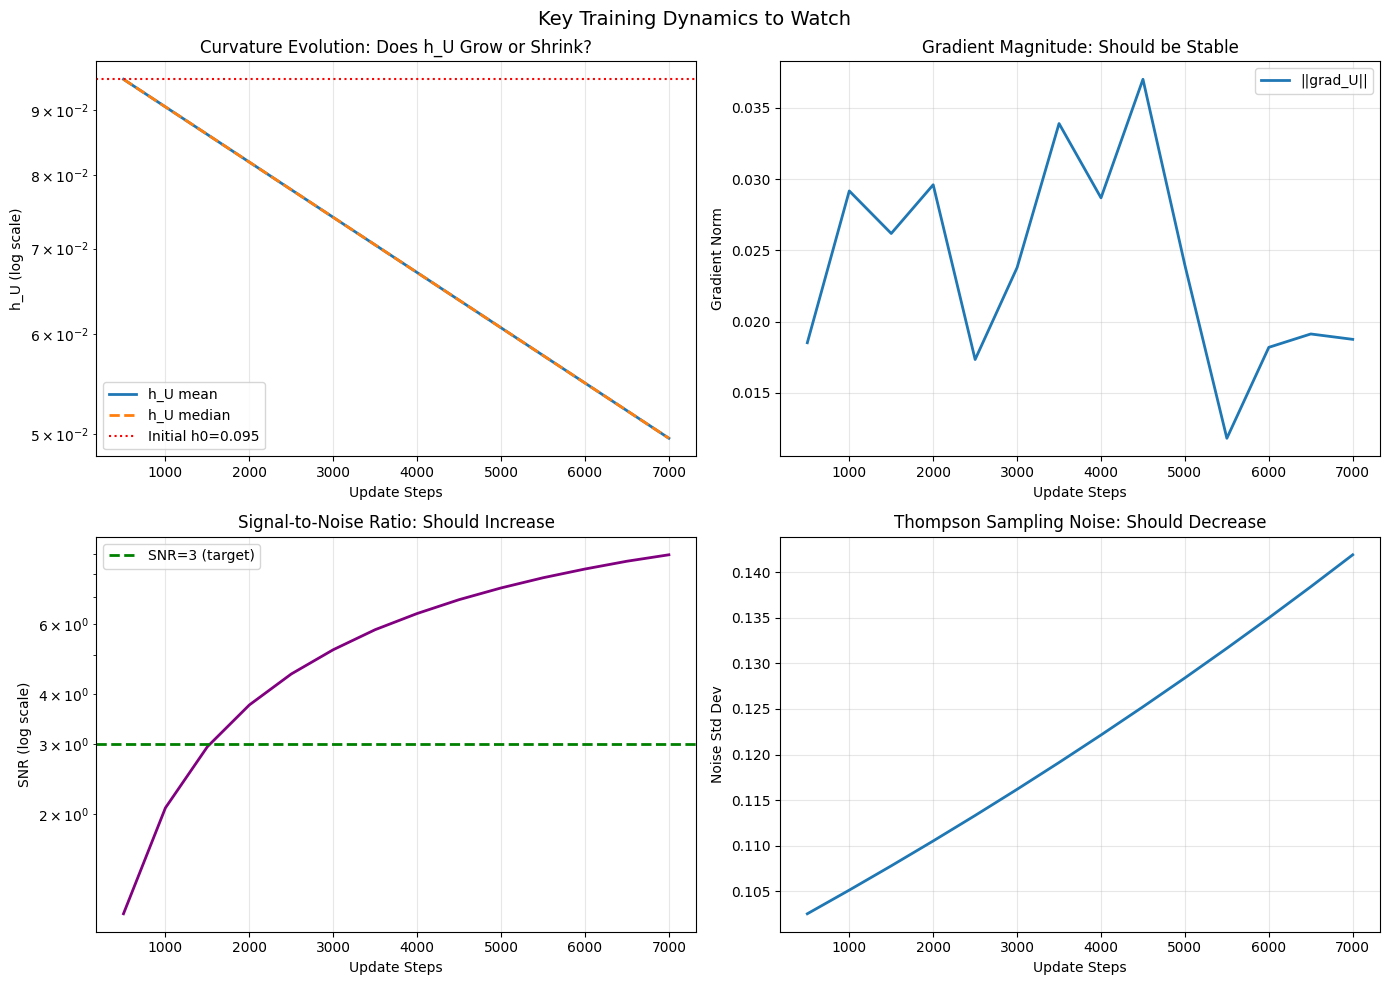


📊 Interpretation Guide:
1. h_U should INCREASE if gradients are larger than h0
   - If decreasing: gradients are too small, reduce h0

2. Gradient norm should stabilize (not explode or vanish)
   - If too high: reduce learning rate
   - If too low: increase learning rate or check data

3. SNR should INCREASE and reach >3 by end of training
   - If stuck below 3: learning is too weak or noise too high

4. Noise should DECREASE as h_U accumulates
   - If increasing: h_U is decaying (problem!)


In [58]:
# Deep dive into key training dynamics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. h_U evolution - the key issue!
ax = axes[0, 0]
ax.plot(history['update_steps'], history['h_U_mean'], linewidth=2, label='h_U mean')
ax.plot(history['update_steps'], history['h_U_median'], linewidth=2, linestyle='--', label='h_U median')
ax.axhline(y=history['h_U_mean'][0], color='red', linestyle=':', label=f'Initial h0={history["h_U_mean"][0]:.3f}')
ax.set_xlabel('Update Steps')
ax.set_ylabel('h_U (log scale)')
ax.set_title('Curvature Evolution: Does h_U Grow or Shrink?')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# 2. Gradient magnitude over time
ax = axes[0, 1]
ax.plot(history['update_steps'], history['grad_U_norm'], linewidth=2, label='||grad_U||')
ax.set_xlabel('Update Steps')
ax.set_ylabel('Gradient Norm')
ax.set_title('Gradient Magnitude: Should be Stable')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Signal-to-Noise Ratio
ax = axes[1, 0]
snr = np.array(history['U_norm']) / (np.array(history['noise_std_U']) * np.sqrt(len(history['U_norm'])))
ax.plot(history['update_steps'], snr, linewidth=2, color='purple')
ax.axhline(y=3, color='green', linestyle='--', linewidth=2, label='SNR=3 (target)')
ax.set_xlabel('Update Steps')
ax.set_ylabel('SNR (log scale)')
ax.set_title('Signal-to-Noise Ratio: Should Increase')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# 4. Noise level over time
ax = axes[1, 1]
ax.plot(history['update_steps'], history['noise_std_U'], linewidth=2)
ax.set_xlabel('Update Steps')
ax.set_ylabel('Noise Std Dev')
ax.set_title('Thompson Sampling Noise: Should Decrease')
ax.grid(True, alpha=0.3)

plt.suptitle('Key Training Dynamics to Watch', fontsize=14)
plt.tight_layout()
plt.show()

# Interpretation guide
print("\n📊 Interpretation Guide:")
print("=" * 70)
print("1. h_U should INCREASE if gradients are larger than h0")
print("   - If decreasing: gradients are too small, reduce h0")
print("")
print("2. Gradient norm should stabilize (not explode or vanish)")
print("   - If too high: reduce learning rate")
print("   - If too low: increase learning rate or check data")
print("")
print("3. SNR should INCREASE and reach >3 by end of training")
print("   - If stuck below 3: learning is too weak or noise too high")
print("")
print("4. Noise should DECREASE as h_U accumulates")
print("   - If increasing: h_U is decaying (problem!)")
print("=" * 70)